In [277]:
from matplotlib.pyplot import *
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from statistics import mode

In [278]:
class LIF:
    def __init__(self, I, t_total_ms=100, dt_ms=0.125, R=1, C=10, threshold=5, neuron_type='Excitatory', 
                 u_rest=0, u_start=-80, u_reset=-65, u_spike = 5):
        self.t_total_ms = t_total_ms
        self.dt_ms = dt_ms
        self.I = I
        self.R = R
        self.C = C
        self.threshold = threshold
        self.t_arr = []
        self.t_current = 0
        self.type = neuron_type
        self.latest_spike = -1
        self.u_start = u_start
        self.u_rest = u_rest
        self.u_reset = u_reset
        self.u_spike = u_spike
        self.u_arr = []
        self.is_spike = False

    def run(self):
        self.t_arr = np.arange(0, self.t_total_ms + self.dt_ms, self.dt_ms)
        self.u_arr = [0 for i in range(len(self.t_arr))]
        
        for t in range(len(self.t_arr)):
            self.t_current = t
            self.is_spike = False
            self.u_arr[t] = self.u_arr[t-1] + (((-self.u_arr[t-1] + self.u_rest) + self.R * self.I(t)) * self.dt_ms)/(self.R * self.C)
            
            if self.u_arr[t] >= self.threshold or self.u_arr[t] < self.u_rest:
                self.u_arr[t] = self.u_rest
                self.latest_spike = self.t_current * self.dt_ms
                self.is_spike = True
                
            yield self.is_spike
            
        
    def u_plot(self):
        plot(self.t_arr, self.u_arr)
        ylabel('U')
        xlabel('t')
            
        
   


In [279]:
class NeuronsGroup:

  def __init__(self, neurons, connections,weights_arr, exc_d=1, inh_d=1, total_time=800):
    self.neurons = neurons
    self.neroun_action = []
    for i in neurons:
      self.neroun_action.append(i.run())
    self.exc_d = exc_d
    self.inh_d =  inh_d
    self.weights_arr = weights_arr
    self.connections = connections
    self.total_time = total_time
    self.spikes = []
    self.t_exc_spikes = []
    self.exc_spikes = []
    self.t_inh_spikes = []
    self.inh_spikes = []
    self.s_effect = []
    
  def run(self):
    self.spikes_effect = [[0] * len(self.neurons) for x in range(self.total_time)]
    for t in range(self.total_time):
    
      for i in range(len(self.neroun_action)):

        action_info = next(self.neroun_action[i])
        if action_info == True :
          
          for j in self.connections[i]:
            if self.neurons[i].type == 'Excitatory':
              self.exc_spikes.append(i + 1)
              self.t_exc_spikes.append(t)
              if t+self.exc_d < self.total_time:
                self.spikes_effect[t + self.exc_d][j] += self.weights_arr[i][j]

            if self.neurons[i].type == 'Inhibitory':
              self.inh_spikes.append(i + 1)
              self.t_inh_spikes.append(t)
              if t + self.inh_d < self.total_time:
                self.spikes_effect[t+self.inh_d][j] -= self.weights_arr[i][j]
      for i in range(len(self.neurons)):
        self.neurons[i].u_arr[self.neurons[i].t_current] += self.spikes_effect[t][i]
      yield True
    yield False
      


  def u_plot(self, n_neurons=3):
    if n_neurons < len(self.neurons):
      for i in range(n_neurons):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr, label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
    else:
      for i in range(len(self.neurons)):
        arr = list(map(lambda p: self.neurons[i].dt_ms * p, range(len(self.neurons[i].u_arr))))
        plt.plot(arr, self.neurons[i].u_arr , label = "neuron " + str(i+1))
        plt.legend(loc="lower right")
        
  def raster_plot(self):
    plt.scatter(self.t_inh_spikes, self.inh_spikes, color='blue', label = 'Inhibitory')
    plt.scatter(self.t_exc_spikes, self.exc_spikes, color='green', label = 'Excitatory')
    plt.legend(loc="lower right")      

In [280]:
class stdp:
    def __init__(self, group, a_pos, a_neg, d_pos, d_neg):
        self.group = group
        self.a_pos = a_pos
        self.a_neg = a_neg
        self.d_pos = d_pos
        self.d_neg = d_neg
        self.w = []
        
    def train(self):
        x = self.group.run()
        while next(x):
            temp_arr = []
            for t1 in self.group.weights_arr:
                temp_prime = []
                for w in t1:
                    temp_prime.append(w)
                temp_arr.append(temp_prime)
            self.w.append(temp_arr)
            
            for i in range(len(self.group.neurons)):
                for j in self.group.connections[i]:
                    dt = self.group.neurons[j].latest_spike - self.group.neurons[i].latest_spike
                    value = 0
                    if dt > 0:
                        value = math.exp(math.fabs(dt)/self.d_pos) * self.a_pos
                    elif dt < 0:
                        value = math.exp(math.fabs(dt)/self.d_neg) * self.a_neg
                    self.group.weights_arr[i][j] += value
                    
                    if self.group.weights_arr[i][j] <= 0:
                        self.group.weights_arr[i][j] = 0
                        
    def w_plot(self, i, j):
        time = []
        for t in self.w:
            time.append(t[i][j])
        plot_x = list(map(lambda x: x * self.group.neurons[i].dt_ms, range(len((time)))))
        plt.plot(plot_x , time)
                        

In [281]:
I = lambda x: 1000*math.cos(x)
neuron_1 = LIF(I=I)
neuron_2 = LIF(I=I)
neuron_3 = LIF(I=lambda x: 1000)
connections = [[1, 2], [0, 2], [0, 1]]
neurons = [neuron_1, neuron_2, neuron_3]

In [282]:
weights_arr = []
for i in range(3):
    t = []
    for j in range(3):
        t.append(random.randint(1, 4))
        if i == j:
            t[j] = 0
    weights_arr.append(t)

In [283]:
group = NeuronsGroup(neurons, connections, weights_arr)
STDP = stdp(group, 2, -3, 0.3, 0.4)
STDP.train()

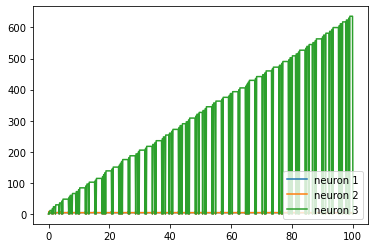

In [284]:
group.u_plot()

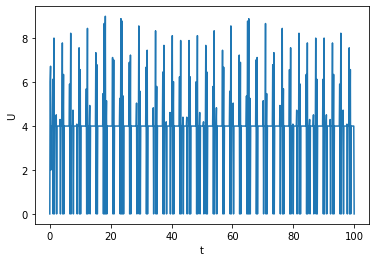

In [285]:
neuron_1.u_plot()

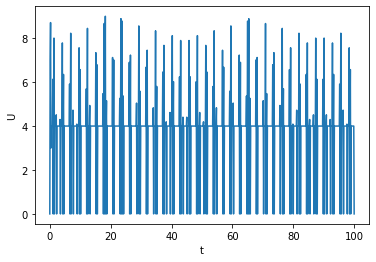

In [286]:
neuron_2.u_plot()

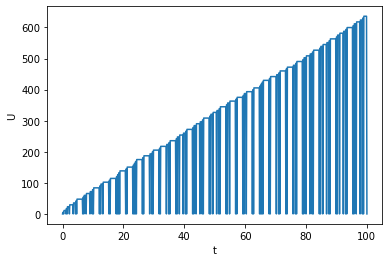

In [287]:
neuron_3.u_plot()

In [288]:
print(weights_arr)

[[0, 4, 318.51453364874806], [4, 0, 317.51453364874806], [0, 0, 0]]


### Sin input

In [289]:
I = lambda x: (math.sin(x) + 0.01) * 1500
neuron_1 = LIF(I=I)
neuron_2 = LIF(I=I)
neuron_3 = LIF(I=I)
connections = [[1, 2], [0, 2], [0, 1]]
neurons = [neuron_1, neuron_2, neuron_3]

In [290]:
weights_arr = []
for i in range(3):
    t = []
    for j in range(3):
        t.append(random.randint(1, 4))
        if i == j:
            t[j] = 0
    weights_arr.append(t)

In [291]:
group = NeuronsGroup(neurons, connections, weights_arr)
STDP = stdp(group, 2, -3, 0.3, 0.4)
STDP.train()

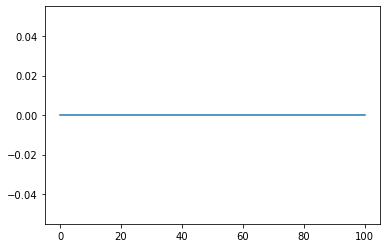

In [292]:
STDP.w_plot(2 ,2)

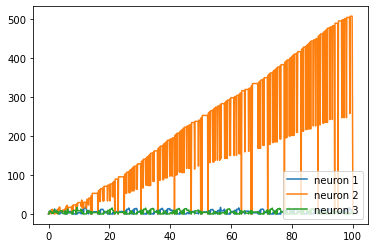

In [293]:
group.u_plot()

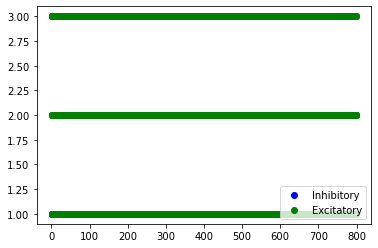

In [294]:
group.raster_plot()

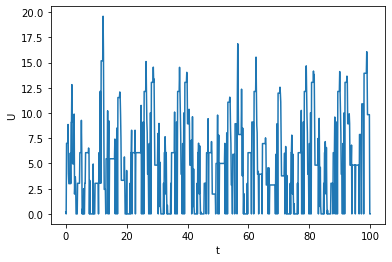

In [295]:
neuron_1.u_plot()

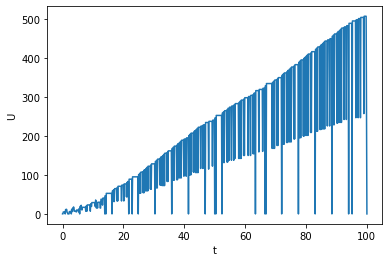

In [296]:
neuron_2.u_plot()

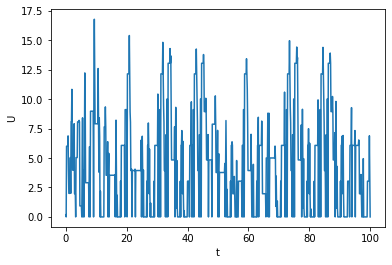

In [297]:
neuron_3.u_plot()

In [298]:
print(weights_arr)

[[0, 250.1728656972176, 0], [0, 0, 0], [12.869160402933746, 260.73988187931405, 0]]
